<a href="https://colab.research.google.com/github/NickN94/AI-Learning-Center/blob/main/PILOT_AI_TRADINGBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🚀 Paketinstallation
!pip install stable-baselines3[extra] optuna shap ta lightgbm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:0

In [2]:
!pip install shimmy

In [3]:
!pip install gymnasium==0.28.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.1
    Uninstalling gymnasium-1.1.1:
      Successfully uninstalled gymnasium-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.28.1 which is incompatible.
stable-baselines3 2.6.0 requires gymnasium<1.2.0,>=0.29.1, but you have gymnasium 0.28.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.28.1 which is incompatible.


In [4]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import logging

# Logging konfigurieren
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class CoinbaseDataFetcher:
    def __init__(self):
        self.base_url = "https://api.exchange.coinbase.com"
        self.headers = {
            'Accept': 'application/json',
            'User-Agent': 'Mozilla/5.0'  # Hilft manchmal bei API-Stabilitätsproblemen
        }
        self.max_retries = 5
        self.retry_delay = 2

    def _make_request(self, url, params):
        """
        Führt eine API-Anfrage mit Retry-Logik durch
        """
        for attempt in range(self.max_retries):
            try:
                response = requests.get(
                    url,
                    params=params,
                    headers=self.headers,
                    timeout=30
                )

                if response.status_code == 200:
                    return response.json()
                elif response.status_code == 429:  # Rate limit
                    wait_time = int(response.headers.get('Retry-After', self.retry_delay))
                    logger.warning(f"Rate limit erreicht. Warte {wait_time} Sekunden...")
                    time.sleep(wait_time)
                else:
                    logger.warning(f"Fehler {response.status_code}: {response.text}")
                    time.sleep(self.retry_delay * (attempt + 1))

            except requests.exceptions.RequestException as e:
                logger.error(f"Netzwerkfehler: {e}")
                time.sleep(self.retry_delay * (attempt + 1))

        raise Exception(f"Maximale Anzahl von Versuchen ({self.max_retries}) erreicht")

    def get_bitcoin_price_history(self):
        """
        Ruft die Bitcoin-Preishistorie der letzten 10 Jahre ab
        """
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365*10)
        all_candles = []
        current_start = start_date

        while current_start < end_date:
            current_end = min(current_start + timedelta(days=300), end_date)

            params = {
                'start': current_start.isoformat(),
                'end': current_end.isoformat(),
                'granularity': 86400  # Tägliche Daten
            }

            try:
                candles = self._make_request(
                    f"{self.base_url}/products/BTC-USD/candles",
                    params
                )

                if candles:
                    all_candles.extend(candles)
                    logger.info(f"Daten erfolgreich abgerufen von {current_start.date()} bis {current_end.date()}")

                # Warte zwischen den Anfragen
                time.sleep(0.5)

            except Exception as e:
                logger.error(f"Fehler beim Abrufen der Daten für Zeitraum "
                           f"{current_start.date()} - {current_end.date()}: {e}")

            current_start = current_end

        if not all_candles:
            raise Exception("Keine Daten konnten abgerufen werden")

        return self._create_dataframe(all_candles)

    def _create_dataframe(self, candles):
        """
        Erstellt und formatiert den DataFrame aus den Rohdaten
        """
        df = pd.DataFrame(
            candles,
            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
        )

        # Konvertiere Unix-Timestamp zu lesbarem Datum
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

        # Konvertiere Preise zu Float
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = df[col].astype(float)

        # Sortiere nach Datum
        df = df.sort_values('timestamp')
        df.set_index('timestamp', inplace=True)

        return df

def save_to_csv(df, filename='bitcoin_history.csv'):
    """
    Speichert die Daten in eine CSV-Datei
    """
    df.to_csv(filename)
    logger.info(f"Daten wurden in {filename} gespeichert")

# Beispielnutzung
if __name__ == "__main__":
    try:
        fetcher = CoinbaseDataFetcher()
        df = fetcher.get_bitcoin_price_history()
        save_to_csv(df)

        print("\nStatistiken der geladenen Daten:")
        print(f"Zeitraum: {df.index.min()} bis {df.index.max()}")
        print(f"Anzahl der Datenpunkte: {len(df)}")
        print("\nErste Einträge:")
        print(df.head())

    except Exception as e:
        logger.error(f"Fehler im Hauptprogramm: {e}")


Statistiken der geladenen Daten:
Zeitraum: 2015-07-23 00:00:00 bis 2025-07-19 00:00:00
Anzahl der Datenpunkte: 3650

Erste Einträge:
              open    high     low   close       volume
timestamp                                              
2015-07-23  276.28  279.75  277.96  277.39  5306.919575
2015-07-24  276.43  291.52  277.23  289.12  7362.469083
2015-07-25  286.82  291.67  289.12  289.70  4102.452960
2015-07-26  288.65  294.49  289.68  293.89  3735.246603
2015-07-27  287.24  297.00  293.88  294.21  6461.033135


BTC 5m: (45282, 6)
BTC 6h: (629, 6)
BTC 1d: (157, 6)
BTC 15m: (261069, 6)
BTC 1h: (65279, 6)
BTC 4h: (16335, 6)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Binary Long Classifier Evaluation
F1 Score: 0.18611865063978286
Recall: 0.20743301642178047


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:20:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Binary Short Classifier Evaluation
F1 Score: 0.24485798237022527
Recall: 0.4826254826254826


 99%|===================| 10495/10580 [00:44<00:00]       

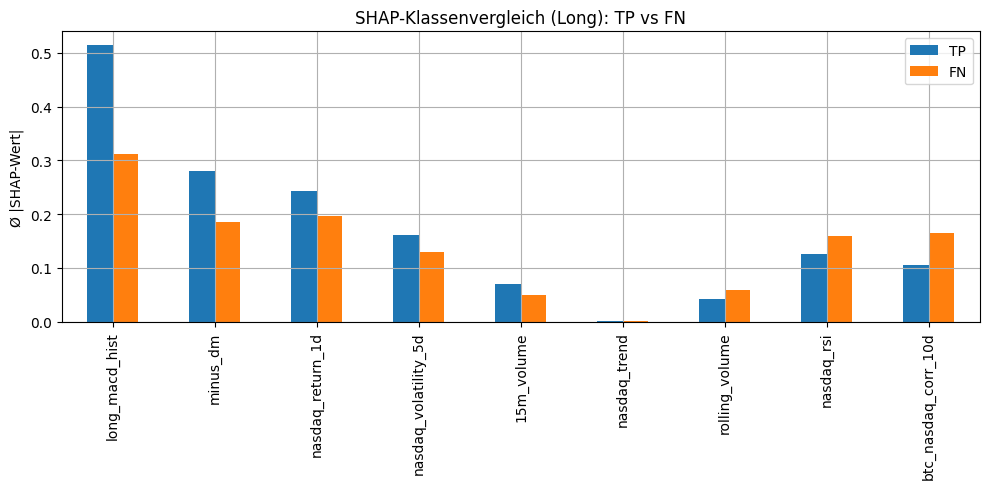

 97%|=================== | 10311/10580 [00:40<00:01]       

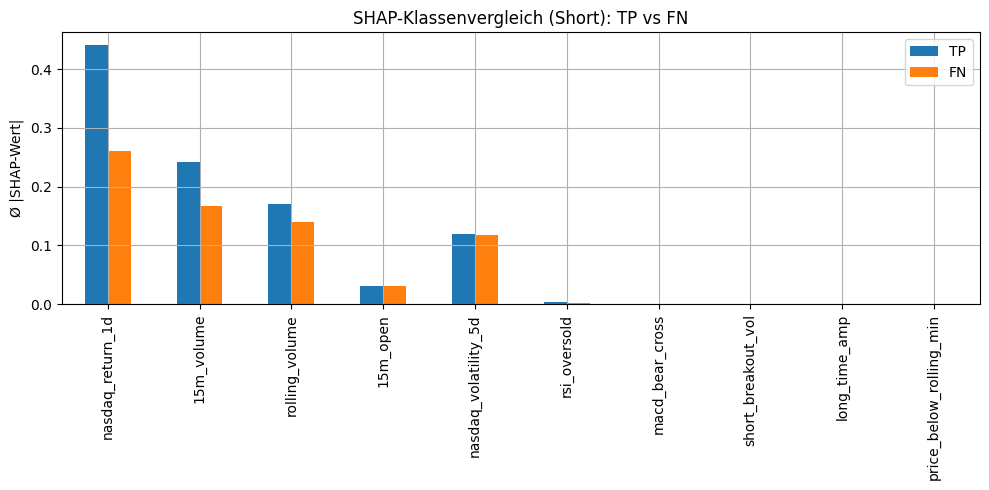

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:22:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:22:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Bundles mit Modell, Features und Schwellenwert gespeichert.

🔍 LONG Signal Evaluation
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     47111
           1       0.25      0.71      0.37      5787

    accuracy                           0.74     52898
   macro avg       0.60      0.73      0.60     52898
weighted avg       0.88      0.74      0.78     52898

MCC: 0.3054317348165064

🔍 SHORT Signal Evaluation
              precision    recall  f1-score   support

           0       0.93      0.79      0.86     45662
           1       0.33      0.64      0.43      7236

    accuracy                           0.77     52898
   macro avg       0.63      0.72      0.64     52898
weighted avg       0.85      0.77      0.80     52898

MCC: 0.33512914824263257
                 datetime  long_prob  short_prob  signal_long  signal_short  \
52918 2025-06-12 20:30:00   0.501380    0.430992            1             0   
52919 2025-06-12 20:45:0

In [5]:
#ML Modell -1
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# === Bestehende Datensätze laden ===
btc_history_df = pd.read_csv('bitcoin_history.csv')
btc_5m_df = pd.read_csv('BTC_5m.csv')
btc_6h_df = pd.read_csv('BTC_6h.csv')

btc_history_df['timestamp'] = pd.to_datetime(btc_history_df['timestamp'])
btc_5m_df['datetime'] = pd.to_datetime(btc_5m_df['datetime'])
btc_6h_df['datetime'] = pd.to_datetime(btc_6h_df['datetime'])

# Gemeinsamen Zeitrahmen definieren (basierend auf 5m, 6h und daily)
start_time = max(
    btc_history_df['timestamp'].min(),
    btc_5m_df['datetime'].min(),
    btc_6h_df['datetime'].min()
)
end_time = min(
    btc_history_df['timestamp'].max(),
    btc_5m_df['datetime'].max(),
    btc_6h_df['datetime'].max()
)

# Filterung
btc_history_df = btc_history_df[(btc_history_df['timestamp'] >= start_time) & (btc_history_df['timestamp'] <= end_time)]
btc_5m_df = btc_5m_df[(btc_5m_df['datetime'] >= start_time) & (btc_5m_df['datetime'] <= end_time)]
btc_6h_df = btc_6h_df[(btc_6h_df['datetime'] >= start_time) & (btc_6h_df['datetime'] <= end_time)]

# NaNs entfernen
btc_history_df_cleaned = btc_history_df.dropna()
btc_5m_df_cleaned = btc_5m_df.dropna()
btc_6h_df_cleaned = btc_6h_df.dropna()

# === Neue Zeitreihen laden und vereinheitlichen ===
def prepare_df(path):
    df = pd.read_csv(path)

    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    return df.dropna()

btc_15m_df_cleaned = prepare_df('Bereinigte_15m_Daten.csv')
btc_1h_df_cleaned = prepare_df('btc_1h_data_cleaned.csv')
btc_4h_df_cleaned = prepare_df('btc_4h_data_cleaned.csv')

# Zeitrahmen für neue Daten synchronisieren
start_time_new = max(
    btc_15m_df_cleaned['datetime'].min(),
    btc_1h_df_cleaned['datetime'].min(),
    btc_4h_df_cleaned['datetime'].min()
)
end_time_new = min(
    btc_15m_df_cleaned['datetime'].max(),
    btc_1h_df_cleaned['datetime'].max(),
    btc_4h_df_cleaned['datetime'].max()
)

btc_15m_df_cleaned = btc_15m_df_cleaned[(btc_15m_df_cleaned['datetime'] >= start_time_new) & (btc_15m_df_cleaned['datetime'] <= end_time_new)]
btc_1h_df_cleaned = btc_1h_df_cleaned[(btc_1h_df_cleaned['datetime'] >= start_time_new) & (btc_1h_df_cleaned['datetime'] <= end_time_new)]
btc_4h_df_cleaned = btc_4h_df_cleaned[(btc_4h_df_cleaned['datetime'] >= start_time_new) & (btc_4h_df_cleaned['datetime'] <= end_time_new)]

btc_15m_df_cleaned = btc_15m_df_cleaned.dropna()
btc_1h_df_cleaned = btc_1h_df_cleaned.dropna()
btc_4h_df_cleaned = btc_4h_df_cleaned.dropna()

# === Ergebnis anzeigen ===
print("BTC 5m:", btc_5m_df_cleaned.shape)
print("BTC 6h:", btc_6h_df_cleaned.shape)
print("BTC 1d:", btc_history_df_cleaned.shape)
print("BTC 15m:", btc_15m_df_cleaned.shape)
print("BTC 1h:", btc_1h_df_cleaned.shape)
print("BTC 4h:", btc_4h_df_cleaned.shape)


#----Feature Engineering

# Funktion zum Berechnen des SMA
def add_sma(df, window):
    df[f'sma_{window}'] = df['close'].rolling(window=window).mean()

# Funktion zum Berechnen des EMA
def add_ema(df, window):
    df[f'ema_{window}'] = df['close'].ewm(span=window, adjust=False).mean()

# Funktion zum Berechnen des RSI
def add_rsi(df, window=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df[f'rsi_{window}'] = 100 - (100 / (1 + rs))

# Funktion zum Berechnen des MACD
def add_macd(df):
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Funktion zum Berechnen der Bollinger Bänder
def add_bollinger_bands(df, window=20):
    df['bollinger_middle'] = df['close'].rolling(window=window).mean()
    df['bollinger_std'] = df['close'].rolling(window=window).std()
    df['bollinger_upper'] = df['bollinger_middle'] + (df['bollinger_std'] * 2)
    df['bollinger_lower'] = df['bollinger_middle'] - (df['bollinger_std'] * 2)

# Funktion zum Berechnen des Stochastic Oscillator
def add_stochastic_oscillator(df, window=14):
    low_min = df['low'].rolling(window=window).min()
    high_max = df['high'].rolling(window=window).max()
    df['stochastic_k'] = 100 * (df['close'] - low_min) / (high_max - low_min)
    df['stochastic_d'] = df['stochastic_k'].rolling(window=3).mean()

# Funktion zum Berechnen des On-Balance Volume (OBV)
def add_obv(df):
    df['obv'] = np.where(df['close'] > df['close'].shift(1), df['volume'],
                         np.where(df['close'] < df['close'].shift(1), -df['volume'], 0))
    df['obv'] = df['obv'].cumsum()

# Anwendung auf 5-Minuten-Daten (btc_5m_df_cleaned)
add_sma(btc_5m_df_cleaned, 20)
add_ema(btc_5m_df_cleaned, 12)
add_ema(btc_5m_df_cleaned, 26)
add_rsi(btc_5m_df_cleaned)
add_macd(btc_5m_df_cleaned)
add_bollinger_bands(btc_5m_df_cleaned)
add_stochastic_oscillator(btc_5m_df_cleaned)
add_obv(btc_5m_df_cleaned)

# Anwendung auf 6-Stunden-Daten (btc_6h_df_cleaned)
add_sma(btc_6h_df_cleaned, 20)
add_ema(btc_6h_df_cleaned, 12)
add_ema(btc_6h_df_cleaned, 26)
add_rsi(btc_6h_df_cleaned)
add_macd(btc_6h_df_cleaned)
add_bollinger_bands(btc_6h_df_cleaned)
add_stochastic_oscillator(btc_6h_df_cleaned)
add_obv(btc_6h_df_cleaned)

# Anwendung auf tägliche Daten (btc_history_df_cleaned)
add_sma(btc_history_df_cleaned, 20)
add_ema(btc_history_df_cleaned, 12)
add_ema(btc_history_df_cleaned, 26)
add_rsi(btc_history_df_cleaned)
add_macd(btc_history_df_cleaned)
add_bollinger_bands(btc_history_df_cleaned)
add_stochastic_oscillator(btc_history_df_cleaned)
add_obv(btc_history_df_cleaned)

# === Erweiterung auf 15-Minuten-Daten ===
add_sma(btc_15m_df_cleaned, 20)
add_ema(btc_15m_df_cleaned, 12)
add_ema(btc_15m_df_cleaned, 26)
add_rsi(btc_15m_df_cleaned)
add_macd(btc_15m_df_cleaned)
add_bollinger_bands(btc_15m_df_cleaned)
add_stochastic_oscillator(btc_15m_df_cleaned)
add_obv(btc_15m_df_cleaned)

# === Erweiterung auf 1-Stunden-Daten ===
add_sma(btc_1h_df_cleaned, 20)
add_ema(btc_1h_df_cleaned, 12)
add_ema(btc_1h_df_cleaned, 26)
add_rsi(btc_1h_df_cleaned)
add_macd(btc_1h_df_cleaned)
add_bollinger_bands(btc_1h_df_cleaned)
add_stochastic_oscillator(btc_1h_df_cleaned)
add_obv(btc_1h_df_cleaned)

# === Erweiterung auf 4-Stunden-Daten ===
add_sma(btc_4h_df_cleaned, 20)
add_ema(btc_4h_df_cleaned, 12)
add_ema(btc_4h_df_cleaned, 26)
add_rsi(btc_4h_df_cleaned)
add_macd(btc_4h_df_cleaned)
add_bollinger_bands(btc_4h_df_cleaned)
add_stochastic_oscillator(btc_4h_df_cleaned)
add_obv(btc_4h_df_cleaned)

# Funktion zum Berechnen des Donchian Channels
def add_donchian_channels(df, window=20):
    df['donchian_upper'] = df['high'].rolling(window=window).max()
    df['donchian_lower'] = df['low'].rolling(window=window).min()
    df['donchian_middle'] = (df['donchian_upper'] + df['donchian_lower']) / 2

# Funktion zum Berechnen des Ichimoku Clouds
def add_ichimoku(df):
    high_9 = df['high'].rolling(window=9).max()
    low_9 = df['low'].rolling(window=9).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2  # Conversion line

    high_26 = df['high'].rolling(window=26).max()
    low_26 = df['low'].rolling(window=26).min()
    df['kijun_sen'] = (high_26 + low_26) / 2  # Base line

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    high_52 = df['high'].rolling(window=52).max()
    low_52 = df['low'].rolling(window=52).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)

    df['chikou_span'] = df['close'].shift(-26)

# Funktion zum Berechnen des Parabolic SAR
def add_parabolic_sar(df, af=0.02, max_af=0.2):
    df['sar'] = df['close'].copy()
    # Placeholder for SAR logic, implement Parabolic SAR calculation here
    # This requires more advanced logic than a simple example.

# Funktion zum Berechnen des VWAP
def add_vwap(df):
    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

# Anwendung auf BTC 5-Minuten-Daten
add_donchian_channels(btc_5m_df_cleaned)
add_ichimoku(btc_5m_df_cleaned)
add_parabolic_sar(btc_5m_df_cleaned)
add_vwap(btc_5m_df_cleaned)

# Anwendung auf BTC 6-Stunden-Daten
add_donchian_channels(btc_6h_df_cleaned)
add_ichimoku(btc_6h_df_cleaned)
add_parabolic_sar(btc_6h_df_cleaned)
add_vwap(btc_6h_df_cleaned)

# Anwendung auf BTC Daily-Daten
add_donchian_channels(btc_history_df_cleaned)
add_ichimoku(btc_history_df_cleaned)
add_parabolic_sar(btc_history_df_cleaned)
add_vwap(btc_history_df_cleaned)

# === Erweiterung: Anwendung auf BTC 15-Minuten-Daten ===
add_donchian_channels(btc_15m_df_cleaned)
add_ichimoku(btc_15m_df_cleaned)
add_parabolic_sar(btc_15m_df_cleaned)
add_vwap(btc_15m_df_cleaned)

# === Erweiterung: Anwendung auf BTC 1-Stunden-Daten ===
add_donchian_channels(btc_1h_df_cleaned)
add_ichimoku(btc_1h_df_cleaned)
add_parabolic_sar(btc_1h_df_cleaned)
add_vwap(btc_1h_df_cleaned)

# === Erweiterung: Anwendung auf BTC 4-Stunden-Daten ===
add_donchian_channels(btc_4h_df_cleaned)
add_ichimoku(btc_4h_df_cleaned)
add_parabolic_sar(btc_4h_df_cleaned)
add_vwap(btc_4h_df_cleaned)

# Überprüfen der ersten Zeilen nach der Berechnung
btc_5m_df_cleaned.head(), \
btc_6h_df_cleaned.head(), \
btc_history_df_cleaned.head(), \
btc_15m_df_cleaned.head(), \
btc_1h_df_cleaned.head(), \
btc_4h_df_cleaned.head()

# Funktion zum Berechnen des Average True Range (ATR)
def add_atr(df, window=14):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift(1)).abs()
    low_close = (df['low'] - df['close'].shift(1)).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1)
    df['atr'] = tr.max(axis=1).rolling(window=window).mean()

# Funktion zum Berechnen des Average Directional Index (ADX)
def add_adx(df, window=14):
    # Berechne die True Range (TR)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = (df['high'] - df['close'].shift()).abs()
    df['low_close'] = (df['low'] - df['close'].shift()).abs()

    # Maximalwert der drei
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

    # Berechne Plus und Minus Directional Movement (DM)
    df['plus_dm'] = df['high'].diff()
    df['minus_dm'] = df['low'].diff()

    df['plus_dm'] = df['plus_dm'].where(df['plus_dm'] > 0, 0)
    df['minus_dm'] = df['minus_dm'].where(df['minus_dm'] > 0, 0)

    # Berechne die Directional Indicator (DI) Werte
    df['plus_di'] = (df['plus_dm'].rolling(window=window).sum() / df['tr'].rolling(window=window).sum()) * 100
    df['minus_di'] = (df['minus_dm'].rolling(window=window).sum() / df['tr'].rolling(window=window).sum()) * 100

    # Berechne den ADX (Average Directional Index)
    df['adx'] = (df['plus_di'] - df['minus_di']).abs()
    df['adx'] = df['adx'].rolling(window=window).mean()

# Anwendung auf BTC 5-Minuten-Daten
add_adx(btc_5m_df_cleaned)

# Anwendung auf BTC 6-Stunden-Daten
add_adx(btc_6h_df_cleaned)

# Anwendung auf BTC Daily-Daten
add_adx(btc_history_df_cleaned)

# === Erweiterung: Anwendung auf BTC 15-Minuten-Daten ===
add_adx(btc_15m_df_cleaned)

# === Erweiterung: Anwendung auf BTC 1-Stunden-Daten ===
add_adx(btc_1h_df_cleaned)

# === Erweiterung: Anwendung auf BTC 4-Stunden-Daten ===
add_adx(btc_4h_df_cleaned)

# Funktion zum Berechnen der RSI-Divergenz
def add_rsi_divergence(df, window=14):
    df['rsi'] = 100 - (100 / (1 + (df['close'].diff().where(df['close'].diff() > 0, 0).rolling(window=window).mean() /
                                    df['close'].diff().where(df['close'].diff() < 0, 0).rolling(window=window).mean())))

    df['rsi_divergence'] = np.where(df['close'].diff() > 0, np.nan, df['rsi'])

# Funktion zum Berechnen der Moving Average Crossovers
def add_moving_average_crossovers(df, short_window=20, long_window=50):
    df['sma_short'] = df['close'].rolling(window=short_window).mean()
    df['sma_long'] = df['close'].rolling(window=long_window).mean()
    df['ma_crossover'] = np.where(df['sma_short'] > df['sma_long'], 1, 0)  # 1: Bullish crossover, 0: Bearish crossover

# Funktion zum Berechnen von Heikin-Ashi Kerzen
def add_heikin_ashi(df):
    df['heikin_ashi_open'] = (df['open'] + df['close']) / 2
    df['heikin_ashi_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df['heikin_ashi_uptrend'] = np.where(df['heikin_ashi_close'] > df['heikin_ashi_open'], 1, 0)  # 1: Uptrend, 0: Downtrend

# Funktion zum Berechnen von Volumenspitzen
def add_volume_spikes(df, window=20):
    df['volume_ma'] = df['volume'].rolling(window=window).mean()
    df['volume_spike'] = np.where(df['volume'] > df['volume_ma'] * 1.5, 1, 0)  # 1: Volume spike, 0: No spike

# Anwendung auf BTC 5-Minuten-Daten
add_adx(btc_5m_df_cleaned)
add_rsi_divergence(btc_5m_df_cleaned)
add_moving_average_crossovers(btc_5m_df_cleaned)
add_heikin_ashi(btc_5m_df_cleaned)
add_volume_spikes(btc_5m_df_cleaned)

# Anwendung auf BTC 6-Stunden-Daten
add_adx(btc_6h_df_cleaned)
add_rsi_divergence(btc_6h_df_cleaned)
add_moving_average_crossovers(btc_6h_df_cleaned)
add_heikin_ashi(btc_6h_df_cleaned)
add_volume_spikes(btc_6h_df_cleaned)

# Anwendung auf BTC Daily-Daten
add_adx(btc_history_df_cleaned)
add_rsi_divergence(btc_history_df_cleaned)
add_moving_average_crossovers(btc_history_df_cleaned)
add_heikin_ashi(btc_history_df_cleaned)
add_volume_spikes(btc_history_df_cleaned)

# === Erweiterung: Anwendung auf BTC 15-Minuten-Daten ===
add_adx(btc_15m_df_cleaned)
add_rsi_divergence(btc_15m_df_cleaned)
add_moving_average_crossovers(btc_15m_df_cleaned)
add_heikin_ashi(btc_15m_df_cleaned)
add_volume_spikes(btc_15m_df_cleaned)

# === Erweiterung: Anwendung auf BTC 1-Stunden-Daten ===
add_adx(btc_1h_df_cleaned)
add_rsi_divergence(btc_1h_df_cleaned)
add_moving_average_crossovers(btc_1h_df_cleaned)
add_heikin_ashi(btc_1h_df_cleaned)
add_volume_spikes(btc_1h_df_cleaned)

# === Erweiterung: Anwendung auf BTC 4-Stunden-Daten ===
add_adx(btc_4h_df_cleaned)
add_rsi_divergence(btc_4h_df_cleaned)
add_moving_average_crossovers(btc_4h_df_cleaned)
add_heikin_ashi(btc_4h_df_cleaned)
add_volume_spikes(btc_4h_df_cleaned)

# Funktion zum Berechnen des Rate of Change (ROC)
def add_roc(df, window=12):
    df['roc'] = df['close'].pct_change(periods=window) * 100

# Funktion zum Berechnen des Chaikin Money Flow (CMF)
def add_cmf(df, window=20):
    df['cmf'] = ((df['close'] - df['low']) - (df['high'] - df['close'])) * df['volume']
    df['cmf'] = df['cmf'].rolling(window=window).sum() / df['volume'].rolling(window=window).sum()

# Funktion zum Berechnen der Accumulation/Distribution Line (A/D Line)
def add_ad_line(df):
    df['ad_line'] = ((2 * df['close'] - df['high'] - df['low']) / (df['high'] - df['low'])) * df['volume']
    df['ad_line'] = df['ad_line'].cumsum()

# Funktion zum Berechnen des Commodity Channel Index (CCI)
def add_cci(df, window=20):
    tp = (df['high'] + df['low'] + df['close']) / 3
    sma = tp.rolling(window=window).mean()
    mad = tp.rolling(window=window).apply(lambda x: np.fabs(x - x.mean()).mean())
    df['cci'] = (tp - sma) / (0.015 * mad)

# Funktion zum Berechnen des Elder's Force Index (EFI)
def add_efi(df, window=13):
    df['efi'] = (df['close'] - df['close'].shift(1)) * df['volume']
    df['efi'] = df['efi'].rolling(window=window).sum()

# Funktion zum Berechnen des Money Flow Index (MFI)
def add_mfi(df, window=14):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)

    df['mfi'] = 100 * (positive_flow.rolling(window=window).sum() / negative_flow.rolling(window=window).sum())

# Berechnung der fehlenden Features auf den 5-Minuten-Daten
add_atr(btc_5m_df_cleaned)
add_roc(btc_5m_df_cleaned)
add_cmf(btc_5m_df_cleaned)
add_ad_line(btc_5m_df_cleaned)
add_cci(btc_5m_df_cleaned)
add_efi(btc_5m_df_cleaned)
add_mfi(btc_5m_df_cleaned)

# Berechnung der fehlenden Features auf den 6-Stunden-Daten
add_atr(btc_6h_df_cleaned)
add_roc(btc_6h_df_cleaned)
add_cmf(btc_6h_df_cleaned)
add_ad_line(btc_6h_df_cleaned)
add_cci(btc_6h_df_cleaned)
add_efi(btc_6h_df_cleaned)
add_mfi(btc_6h_df_cleaned)

# Berechnung der fehlenden Features auf den täglichen Daten
add_atr(btc_history_df_cleaned)
add_roc(btc_history_df_cleaned)
add_cmf(btc_history_df_cleaned)
add_ad_line(btc_history_df_cleaned)
add_cci(btc_history_df_cleaned)
add_efi(btc_history_df_cleaned)
add_mfi(btc_history_df_cleaned)

# Berechnung der fehlenden Features auf den 5-Minuten-Daten
add_atr(btc_5m_df_cleaned)
add_roc(btc_5m_df_cleaned)
add_cmf(btc_5m_df_cleaned)
add_ad_line(btc_5m_df_cleaned)
add_cci(btc_5m_df_cleaned)
add_efi(btc_5m_df_cleaned)
add_mfi(btc_5m_df_cleaned)

# Berechnung der fehlenden Features auf den 6-Stunden-Daten
add_atr(btc_6h_df_cleaned)
add_roc(btc_6h_df_cleaned)
add_cmf(btc_6h_df_cleaned)
add_ad_line(btc_6h_df_cleaned)
add_cci(btc_6h_df_cleaned)
add_efi(btc_6h_df_cleaned)
add_mfi(btc_6h_df_cleaned)

# Berechnung der fehlenden Features auf den täglichen Daten
add_atr(btc_history_df_cleaned)
add_roc(btc_history_df_cleaned)
add_cmf(btc_history_df_cleaned)
add_ad_line(btc_history_df_cleaned)
add_cci(btc_history_df_cleaned)
add_efi(btc_history_df_cleaned)
add_mfi(btc_history_df_cleaned)

# Überprüfen der ersten Zeilen nach der Berechnung
btc_5m_df_cleaned.head(), \
btc_6h_df_cleaned.head(), \
btc_history_df_cleaned.head(), \
btc_15m_df_cleaned.head(), \
btc_1h_df_cleaned.head(), \
btc_4h_df_cleaned.head()

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, matthews_corrcoef
)

# --- Funktion: SHAP-basierte Top-Features ---
def add_top_features(df, prefix):
    df = df.copy()

    # Stochastic Oscillator
    low_min = df['low'].rolling(window=14).min()
    high_max = df['high'].rolling(window=14).max()
    df[f'{prefix}stochastic_k'] = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-9)
    df[f'{prefix}stochastic_d'] = df[f'{prefix}stochastic_k'].rolling(window=3).mean()

    # RSI & RSI-Divergenz
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / (loss + 1e-9)
    df[f'{prefix}rsi_14'] = 100 - (100 / (1 + rs))
    df[f'{prefix}rsi_divergence'] = np.where(df['close'].diff() > 0, np.nan, df[f'{prefix}rsi_14'])

    # Heikin-Ashi Uptrend
    df[f'{prefix}heikin_ashi_open'] = (df['open'] + df['close']) / 2
    df[f'{prefix}heikin_ashi_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df[f'{prefix}heikin_ashi_uptrend'] = np.where(df[f'{prefix}heikin_ashi_close'] > df[f'{prefix}heikin_ashi_open'], 1, 0)

    # MA-Crossover
    short_ma = df['close'].rolling(window=20).mean()
    long_ma = df['close'].rolling(window=50).mean()
    df[f'{prefix}ma_crossover'] = np.where(short_ma > long_ma, 1, 0)

    # Ichimoku
    high_26 = df['high'].rolling(window=26).max()
    low_26 = df['low'].rolling(window=26).min()
    high_52 = df['high'].rolling(window=52).max()
    low_52 = df['low'].rolling(window=52).min()
    df[f'{prefix}kijun_sen'] = (high_26 + low_26) / 2
    df[f'{prefix}senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)
    df[f'{prefix}chikou_span'] = df['close'].shift(-26)

    # Bollinger & Donchian
    mid = df['close'].rolling(window=20).mean()
    std = df['close'].rolling(window=20).std()
    df[f'{prefix}bollinger_upper'] = mid + (2 * std)
    df[f'{prefix}bollinger_lower'] = mid - (2 * std)
    df[f'{prefix}donchian_upper'] = df['high'].rolling(window=20).max()
    df[f'{prefix}donchian_lower'] = df['low'].rolling(window=20).min()

    # VWAP
    df[f'{prefix}vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

    # OHLCV
    df[f'{prefix}open'] = df['open']
    df[f'{prefix}high'] = df['high']
    df[f'{prefix}low'] = df['low']
    df[f'{prefix}close'] = df['close']
    df[f'{prefix}volume'] = df['volume']

    return df

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, auc, matthews_corrcoef, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
import shap
from sklearn.decomposition import PCA
from sklearn.utils import resample


# --- CSV-Daten einlesen ---
btc_15m_df = pd.read_csv('Bereinigte_15m_Daten.csv', parse_dates=["datetime"])
btc_1h_df = pd.read_csv('btc_1h_data_cleaned.csv', parse_dates=["datetime"])
btc_4h_df = pd.read_csv('btc_4h_data_cleaned.csv', parse_dates=["datetime"])
nasdaq100_df = pd.read_csv('nasdaq100_cleaned_final.csv', parse_dates=["datetime"])

# --- Feature Engineering ---
# Ensure add_top_features is defined here if not already
def add_top_features(df, prefix):
    df = df.copy()

    # Stochastic Oscillator
    low_min = df['low'].rolling(window=14).min()
    high_max = df['high'].rolling(window=14).max()
    df[f'{prefix}stochastic_k'] = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-9)
    df[f'{prefix}stochastic_d'] = df[f'{prefix}stochastic_k'].rolling(window=3).mean()

    # RSI & RSI-Divergenz
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / (loss + 1e-9)
    df[f'{prefix}rsi_14'] = 100 - (100 / (1 + rs))
    df[f'{prefix}rsi_divergence'] = np.where(df['close'].diff() > 0, np.nan, df[f'{prefix}rsi_14'])

    # Heikin-Ashi Uptrend
    df[f'{prefix}heikin_ashi_open'] = (df['open'] + df['close']) / 2
    df[f'{prefix}heikin_ashi_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df[f'{prefix}heikin_ashi_uptrend'] = np.where(df[f'{prefix}heikin_ashi_close'] > df[f'{prefix}heikin_ashi_open'], 1, 0)

    # MA-Crossover
    short_ma = df['close'].rolling(window=20).mean()
    long_ma = df['close'].rolling(window=50).mean()
    df[f'{prefix}ma_crossover'] = np.where(short_ma > long_ma, 1, 0)

    # Ichimoku
    high_26 = df['high'].rolling(window=26).max()
    low_26 = df['low'].rolling(window=26).min()
    high_52 = df['high'].rolling(window=52).max()
    low_52 = df['low'].rolling(window=52).min()
    df[f'{prefix}kijun_sen'] = (high_26 + low_26) / 2
    df[f'{prefix}senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)
    df[f'{prefix}chikou_span'] = df['close'].shift(-26)

    # Bollinger & Donchian
    mid = df['close'].rolling(window=20).mean()
    std = df['close'].rolling(window=20).std()
    df[f'{prefix}bollinger_upper'] = mid + (2 * std)
    df[f'{prefix}bollinger_lower'] = mid - (2 * std)
    df[f'{prefix}donchian_upper'] = df['high'].rolling(window=20).max()
    df[f'{prefix}donchian_lower'] = df['low'].rolling(window=20).min()

    # VWAP
    df[f'{prefix}vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

    # OHLCV
    df[f'{prefix}open'] = df['open']
    df[f'{prefix}high'] = df['high']
    df[f'{prefix}low'] = df['low']
    df[f'{prefix}close'] = df['close']
    df[f'{prefix}volume'] = df['volume']

    return df

# Ensure add_long_phase_features is defined here if not already
def add_long_phase_features(df, prefix="long_", source_prefix="15m_"):
    df = df.copy()
    high = df[f'{source_prefix}high']
    low = df[f'{source_prefix}low']
    close = df[f'{source_prefix}close']
    open_ = df[f'{source_prefix}open']
    volume = df[f'{source_prefix}volume']

    # Bollinger
    bb_mid = close.rolling(window=20).mean()
    bb_std = close.rolling(window=20).std()
    df[f'{prefix}bb_width'] = (2 * bb_std) / bb_mid

    # ROC & Volumen
    df[f'{prefix}roc'] = close.pct_change(periods=9) * 100
    df[f'{prefix}volume_ma'] = volume.rolling(window=20).mean()

    # Heikin-Ashi
    ha_close = (open_ + high + low + close) / 4
    ha_open = ((open_.shift() + close.shift()) / 2).fillna(open_)
    df[f'{prefix}heikin_up'] = (ha_close > ha_open).astype(int)
    df[f'{prefix}heikin_up_len'] = df[f'{prefix}heikin_up'].groupby((df[f'{prefix}heikin_up'] != df[f'{prefix}heikin_up'].shift()).cumsum()).cumsum()

    # ROC x Volatilität
    df[f'{prefix}roc_bb'] = df[f'{prefix}roc'] * df[f'{prefix}bb_width']
    df[f'{prefix}roc_volatility'] = df[f'{prefix}roc_bb'] * df['rolling_volatility']

    # ADX-Rohdaten
    # Fixed: Ensure 'plus_dm' and 'minus_dm' are correctly calculated based on high/low diff.
    # The original calculation `high.diff().where(high.diff() > low.diff(), 0)` was incorrect.
    # The correct calculation for +DM is max(0, current_high - previous_high) if that's > max(0, previous_low - current_low)
    # The correct calculation for -DM is max(0, previous_low - current_low) if that's > max(0, current_high - previous_high)
    # A simpler approach is to calculate PDM and MDM first, then compare.
    pdm = high.diff().clip(lower=0)
    mdm = -low.diff().clip(upper=0)
    df['plus_dm'] = pdm.where(pdm > mdm, 0)
    df['minus_dm'] = mdm.where(mdm > pdm, 0)

    # Ensure rolling_volatility is calculated before using it in +DI
    df['rolling_volatility'] = df[f'{source_prefix}close'].pct_change().rolling(window=10).std()

    # Fixed: Use ATR or TR for ADX calculation, not rolling_volatility
    # Assuming a simplified TR calculation for this fix
    high_low = high - low
    high_prev_close = (high - close.shift(1)).abs()
    low_prev_close = (low - close.shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    df[f'{prefix}plus_di'] = (df['plus_dm'].rolling(14).sum() / tr.rolling(14).sum().replace(0, np.nan)) * 100 # Add small number to avoid division by zero

    # MACD-Rohwert
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    df[f'{prefix}macd_hist'] = ema12 - ema26

    # RSI
    gain = close.diff().clip(lower=0)
    loss = -close.diff().clip(upper=0)
    # Fixed: Add small number to avoid division by zero
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df[f'{prefix}rsi'] = 100 - (100 / (1 + rs))

    # Interaktion: DI x RSI
    df[f'{prefix}di_rsi'] = df[f'{prefix}plus_di'] * df[f'{prefix}rsi']

    return df

btc_15m = add_top_features(btc_15m_df, prefix="15m_")
btc_1h = add_top_features(btc_1h_df, prefix="1h_")
btc_4h = add_top_features(btc_4h_df, prefix="4h_")

# --- Zeitfelder vereinheitlichen ---
for df in [btc_15m, btc_1h, btc_4h]:
    df['datetime'] = pd.to_datetime(df['datetime'])

# ✅ Neue Zielgrößen zuerst auf 15m vorbereiten (optional früher möglich)
btc_15m = btc_15m.sort_values("datetime").reset_index(drop=True)
future_close = btc_15m['15m_close'].shift(-12)
future_low = btc_15m['15m_low'].shift(-3).rolling(window=12).min()

btc_15m['forward_return'] = (future_close / btc_15m['15m_close']) - 1
btc_15m['max_drawdown_next12'] = (future_low / btc_15m['15m_close']) - 1

upper_return = btc_15m['forward_return'].quantile(0.85)
lower_return = btc_15m['forward_return'].quantile(0.15)
low_drawdown = btc_15m['max_drawdown_next12'].quantile(0.25)
high_drawup = btc_15m['max_drawdown_next12'].quantile(0.75)

btc_15m['target'] = 0
btc_15m.loc[
    (btc_15m['forward_return'] >= upper_return) &
    (btc_15m['max_drawdown_next12'] >= low_drawdown),
    'target'
] = 1
btc_15m.loc[
    (btc_15m['forward_return'] <= lower_return) &
    (btc_15m['max_drawdown_next12'] <= high_drawup),
    'target'
] = -1
btc_15m['target_lgbm'] = btc_15m['target'].map({-1: 0, 0: 1, 1: 2})

# --- Zeitbasierter Merge mit Targets jetzt inkludiert ---
btc_fused = pd.merge_asof(
    btc_15m.sort_values("datetime"),
    btc_1h[["datetime"] + [c for c in btc_1h.columns if c.startswith("1h_")]],
    on="datetime", direction="backward"
)
btc_fused = pd.merge_asof(
    btc_fused.sort_values("datetime"),
    btc_4h[["datetime"] + [c for c in btc_4h.columns if c.startswith("4h_")]],
    on="datetime", direction="backward"
)

# --- NASDAQ Feature Engineering ---
nasdaq = nasdaq100_df.sort_values("datetime").reset_index(drop=True)
nasdaq['nasdaq_return_1d'] = nasdaq['close'].pct_change()
nasdaq['nasdaq_volatility_5d'] = nasdaq['close'].pct_change().rolling(5).std()
nasdaq['nasdaq_trend'] = (nasdaq['close'].rolling(5).mean() > nasdaq['close'].rolling(20).mean()).astype(int)
delta = nasdaq['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss + 1e-9)
nasdaq['nasdaq_rsi'] = 100 - (100 / (1 + rs))

# --- BTC Tagesrendite für Korrelation ---
btc_daily = btc_15m[['datetime', '15m_close']].copy()
btc_daily['date'] = btc_daily['datetime'].dt.date
btc_daily = btc_daily.groupby('date')['15m_close'].last().pct_change().rename("btc_return_1d").reset_index()
btc_daily['datetime'] = pd.to_datetime(btc_daily['date'])

# --- Rollierende Korrelation & Divergenz ---
cor_df = pd.merge(nasdaq[['datetime', 'nasdaq_return_1d']], btc_daily[['datetime', 'btc_return_1d']], on='datetime', how='inner')
cor_df['btc_nasdaq_corr_10d'] = cor_df['nasdaq_return_1d'].rolling(10).corr(cor_df['btc_return_1d'])
nasdaq = pd.merge(nasdaq, cor_df[['datetime', 'btc_nasdaq_corr_10d']], on='datetime', how='left')
nasdaq['btc_nasdaq_divergence'] = (
    ((cor_df['btc_return_1d'] > 0) & (cor_df['nasdaq_return_1d'] < 0)) |
    ((cor_df['btc_return_1d'] < 0) & (cor_df['nasdaq_return_1d'] > 0))
).astype(int)
nasdaq['btc_nasdaq_divergence'] = nasdaq['btc_nasdaq_divergence'].fillna(0)

# --- NASDAQ an BTC anhängen ---
btc_fused = pd.merge_asof(
    btc_fused.sort_values("datetime"),
    nasdaq[[
        "datetime",
        "nasdaq_return_1d",
        "nasdaq_volatility_5d",
        "nasdaq_trend",
        "nasdaq_rsi",
        "btc_nasdaq_corr_10d",
        "btc_nasdaq_divergence"
    ]],
    on="datetime",
    direction="backward"
)

# --- Final Cleanup ---
btc_fused = btc_fused.dropna()

# === 🔹 Neue Zielgrößen: längerer Zeithorizont für Long-Signale ===
btc_fused = btc_fused.sort_values("datetime").reset_index(drop=True)
future_close = btc_fused['15m_close'].shift(-12)
future_low = btc_fused['15m_low'].shift(-3).rolling(window=12).min()

btc_fused['forward_return'] = (future_close / btc_fused['15m_close']) - 1
btc_fused['max_drawdown_next12'] = (future_low / btc_fused['15m_close']) - 1

upper_return = btc_fused['forward_return'].quantile(0.85)
lower_return = btc_fused['forward_return'].quantile(0.15)
low_drawdown = btc_fused['max_drawdown_next12'].quantile(0.25)
high_drawup = btc_fused['max_drawdown_next12'].quantile(0.75)

btc_fused['target'] = 0
btc_fused.loc[
    (btc_fused['forward_return'] >= upper_return) &
    (btc_fused['max_drawdown_next12'] >= low_drawdown),
    'target'
] = 1
btc_fused.loc[
    (btc_fused['forward_return'] <= lower_return) &
    (btc_fused['max_drawdown_next12'] <= high_drawup),
    'target'
] = -1

btc_fused['target_lgbm'] = btc_fused['target'].map({-1: 0, 0: 1, 1: 2})
btc_fused = btc_fused.dropna()

# Zusatzfeatures
btc_fused['hour'] = btc_fused['datetime'].dt.hour
btc_fused['weekday'] = btc_fused['datetime'].dt.weekday
btc_fused['is_weekend'] = (btc_fused['weekday'] >= 5).astype(int)
# Recalculate rolling_volatility before adding long phase features
btc_fused['rolling_volatility'] = btc_fused['15m_close'].pct_change().rolling(window=10).std()
btc_fused['rolling_volume'] = btc_fused['15m_volume'].rolling(window=5).mean()

btc_fused['long_hour_amp'] = btc_fused['hour'].isin([6, 7, 8, 9, 10, 11, 12, 13]).astype(int)
btc_fused['long_weekday_amp'] = btc_fused['weekday'].isin([1, 2, 3]).astype(int)
btc_fused['long_time_amp'] = btc_fused['long_hour_amp'] * btc_fused['long_weekday_amp']

# Neues kombiniertes Feature: Makro-Long-Verstärkung
btc_fused['macro_amp_long'] = btc_fused['nasdaq_trend'] * btc_fused['long_time_amp']
btc_fused['macro_rsi_amp'] = btc_fused['nasdaq_rsi'] * btc_fused['long_time_amp']
btc_fused['macro_vol_amp'] = btc_fused['nasdaq_volatility_5d'] * btc_fused['long_time_amp']

# Recalculate long phase features
btc_fused = add_long_phase_features(btc_fused, prefix="long_", source_prefix="15m_")

# === Fehlende Werte entfernen ===
btc_fused = btc_fused.dropna()

# === Spezialisiertes Binary-Modell für Long (Ensemble-Ansatz) ===
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Zielgröße für spezialisiertes Long-Modell erzeugen
btc_fused['target_binary_long'] = (btc_fused['target'] == 1).astype(int)
btc_fused['target_binary_short'] = (btc_fused['target'] == -1).astype(int)

binary_features_long = btc_fused[[
    'nasdaq_rsi',
    'nasdaq_volatility_5d',
    'nasdaq_return_1d',
    'btc_nasdaq_corr_10d',
    'nasdaq_trend',
    'minus_dm',
    '15m_volume',
    'long_macd_hist',
    'rolling_volume'
]]

X_bin_long = binary_features_long
y_bin_long = btc_fused['target_binary_long']

split = int(len(X_bin_long) * 0.8)
X_bin_train_long, X_bin_test_long = X_bin_long.iloc[:split], X_bin_long.iloc[split:]
y_bin_train_long, y_bin_test_long = y_bin_long.iloc[:split], y_bin_long.iloc[split:]

long_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=5,  # je nach Imbalance ggf. anpassen!
    eval_metric='logloss',
    use_label_encoder=False
)
long_model.fit(X_bin_train_long, y_bin_train_long)

print("\nBinary Long Classifier Evaluation")
print("F1 Score:", f1_score(y_bin_test_long, long_model.predict(X_bin_test_long)))
print("Recall:", recall_score(y_bin_test_long, long_model.predict(X_bin_test_long)))

btc_fused['binary_long_signal'] = long_model.predict(X_bin_long).astype(int)

# === Binary Short Classifier (XGBoost) ===

#Zusatzshort Features
# Rollierendes Minimum über X Perioden (z. B. 12×15min = 3h)
btc_fused['rolling_min_12'] = btc_fused['15m_close'].rolling(window=12).min()
btc_fused['price_below_rolling_min'] = (btc_fused['15m_close'] < btc_fused['rolling_min_12']).astype(int)

btc_fused['rsi_oversold'] = (btc_fused['15m_rsi_14'] < 30).astype(int)
# Starke negative Divergenz: Differenz der RSI-Änderung und Preis-Änderung
btc_fused['rsi_short_divergence'] = ((btc_fused['15m_rsi_14'].diff(3) < -10) & (btc_fused['15m_close'].diff(3) < 0)).astype(int)

btc_fused['volume_spike'] = (btc_fused['15m_volume'] > btc_fused['15m_volume'].rolling(window=20).mean() * 1.5).astype(int)
btc_fused['short_breakout_vol'] = (btc_fused['price_below_rolling_min'] & btc_fused['volume_spike']).astype(int)

ema12 = btc_fused['15m_close'].ewm(span=12).mean()
ema26 = btc_fused['15m_close'].ewm(span=26).mean()
btc_fused['macd'] = ema12 - ema26
btc_fused['macd_signal'] = btc_fused['macd'].ewm(span=9).mean()
btc_fused['macd_bear_cross'] = ((btc_fused['macd'].shift(1) > btc_fused['macd_signal'].shift(1)) &
                                (btc_fused['macd'] <= btc_fused['macd_signal'])).astype(int)

high = btc_fused['15m_high']
low = btc_fused['15m_low']
close = btc_fused['15m_close']
btc_fused['tr'] = np.maximum.reduce([
    high - low,
    (high - close.shift(1)).abs(),
    (low - close.shift(1)).abs()
])
btc_fused['atr_10'] = btc_fused['tr'].rolling(window=10).mean()
btc_fused['atr_spike'] = (btc_fused['atr_10'] > btc_fused['atr_10'].rolling(window=30).mean() * 1.3).astype(int)
btc_fused['atr_spike_down'] = (btc_fused['atr_spike'] & (btc_fused['15m_close'].diff() < 0)).astype(int)

# Sinnvolle dedizierte Features für Short-Signal
short_feature_candidates = [
    '15m_close', '15m_open', '15m_volume',
    'nasdaq_return_1d', 'nasdaq_volatility_5d', 'nasdaq_trend',
    'rolling_volatility', 'rolling_volume',
    'macro_vol_amp', 'macro_amp_long',
    'long_time_amp', 'long_weekday_amp',  # als inverser Marker

    # Neue dedizierte Short-Trigger:
    'price_below_rolling_min',
    'rsi_oversold',
    'rsi_short_divergence',
    'short_breakout_vol',
    'macd_bear_cross',
    'atr_spike_down',
]

binary_features_short = btc_fused[short_feature_candidates].copy()
X_bin_short = binary_features_short
y_bin_short = btc_fused['target_binary_short']

split = int(len(X_bin_short) * 0.8)
X_bin_train_short, X_bin_test_short = X_bin_short.iloc[:split], X_bin_short.iloc[split:]
y_bin_train_short, y_bin_test_short = y_bin_short.iloc[:split], y_bin_short.iloc[split:]

short_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=5,
    eval_metric='logloss',
    use_label_encoder=False
)
short_model.fit(X_bin_train_short, y_bin_train_short)

print("\nBinary Short Classifier Evaluation")
print("F1 Score:", f1_score(y_bin_test_short, short_model.predict(X_bin_test_short)))
print("Recall:", recall_score(y_bin_test_short, short_model.predict(X_bin_test_short)))

btc_fused['binary_short_signal'] = short_model.predict(X_bin_short).astype(int)

# === SHAP-Klassenvergleich für Long ===
import shap
import seaborn as sns

explainer_long = shap.Explainer(long_model, X_bin_test_long)
shap_vals_long = explainer_long(X_bin_test_long)
shap_df_long = pd.DataFrame(shap_vals_long.values, columns=X_bin_test_long.columns)
shap_df_long['true'] = y_bin_test_long.values
shap_df_long['pred'] = long_model.predict(X_bin_test_long)
shap_df_long['type'] = ['TP' if t == 1 and p == 1 else 'FN' if t == 1 and p == 0 else 'Other' for t, p in zip(shap_df_long['true'], shap_df_long['pred'])]

shap_tp_long = shap_df_long[shap_df_long['type'] == 'TP'].drop(columns=['true', 'pred', 'type'])
shap_fn_long = shap_df_long[shap_df_long['type'] == 'FN'].drop(columns=['true', 'pred', 'type'])

mean_tp_long = shap_tp_long.abs().mean()
mean_fn_long = shap_fn_long.abs().mean()
comparison_df_long = pd.DataFrame({'TP': mean_tp_long, 'FN': mean_fn_long})
comparison_df_long['Diff'] = comparison_df_long['TP'] - comparison_df_long['FN']
comparison_df_long = comparison_df_long.sort_values(by='Diff', ascending=False).head(10)

comparison_df_long[['TP', 'FN']].plot(kind='bar', figsize=(10, 5), title='SHAP-Klassenvergleich (Long): TP vs FN')
plt.ylabel('Ø |SHAP-Wert|')
plt.grid(True)
plt.tight_layout()
plt.show()

# === SHAP-Klassenvergleich für Short ===
explainer_short = shap.Explainer(short_model, X_bin_test_short)
shap_vals_short = explainer_short(X_bin_test_short)
shap_df_short = pd.DataFrame(shap_vals_short.values, columns=X_bin_test_short.columns)
shap_df_short['true'] = y_bin_test_short.values
shap_df_short['pred'] = short_model.predict(X_bin_test_short)
shap_df_short['type'] = ['TP' if t == 1 and p == 1 else 'FN' if t == 1 and p == 0 else 'Other' for t, p in zip(shap_df_short['true'], shap_df_short['pred'])]

shap_tp_short = shap_df_short[shap_df_short['type'] == 'TP'].drop(columns=['true', 'pred', 'type'])
shap_fn_short = shap_df_short[shap_df_short['type'] == 'FN'].drop(columns=['true', 'pred', 'type'])

mean_tp_short = shap_tp_short.abs().mean()
mean_fn_short = shap_fn_short.abs().mean()
comparison_df_short = pd.DataFrame({'TP': mean_tp_short, 'FN': mean_fn_short})
comparison_df_short['Diff'] = comparison_df_short['TP'] - comparison_df_short['FN']
comparison_df_short = comparison_df_short.sort_values(by='Diff', ascending=False).head(10)

comparison_df_short[['TP', 'FN']].plot(kind='bar', figsize=(10, 5), title='SHAP-Klassenvergleich (Short): TP vs FN')
plt.ylabel('Ø |SHAP-Wert|')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Rolling Walk Forward Evaluation ===
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd # Import pandas again for clarity
from sklearn.exceptions import NotFittedError

# === Spezialisiertes Binary-Modell für Long (Ensemble-Ansatz) ===
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils import resample
import shap
import numpy as np
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.utils import resample
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, classification_report
import os
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, classification_report
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# ==== TARGETS DEFINITION ====
btc_fused['target_binary_short'] = (btc_fused['target'] == -1).astype(int)
btc_fused['target_binary_long'] = (btc_fused['target'] == 1).astype(int)

window_size = int(len(btc_fused) * 0.2)
step_size = int(window_size * 0.5)

# Final definierte Features für beide Targets
long_features = [
    'nasdaq_rsi', 'nasdaq_volatility_5d', 'nasdaq_return_1d', 'btc_nasdaq_corr_10d',
    'nasdaq_trend', 'minus_dm', '15m_volume', 'long_macd_hist', 'rolling_volume',
    'long_time_amp', 'long_hour_amp', 'long_weekday_amp', 'macro_amp_long', 'macro_rsi_amp', 'macro_vol_amp'
]

short_features = [
    '15m_close', '15m_open', '15m_volume', 'nasdaq_return_1d', 'nasdaq_volatility_5d',
    'nasdaq_trend', 'rolling_volatility', 'rolling_volume', 'macro_vol_amp',
    'volume_spike', 'price_below_rolling_min', 'short_breakout_vol', 'minus_dm','rsi_oversold',
    'rsi_short_divergence', 'macd_bear_cross', 'atr_spike_down'
]

# === Finale Modelle auf dem gesamten Datensatz trainieren und speichern ===
# Annahme: btc_fused, long_features, short_features und die Targets sind bereits definiert
valid_long_features = [f for f in long_features if btc_fused[f].notnull().all() and btc_fused[f].nunique() > 1]
valid_short_features = [f for f in short_features if btc_fused[f].notnull().all() and btc_fused[f].nunique() > 1]

X_valid_long = btc_fused[valid_long_features].astype(np.float32)
X_valid_short = btc_fused[valid_short_features].astype(np.float32)
y_long = btc_fused['target_binary_long']
y_short = btc_fused['target_binary_short']

model_long = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.07, scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss')
model_short = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.07, scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss')

model_long.fit(X_valid_long, y_long)
model_short.fit(X_valid_short, y_short)

# === Finaler Speicherblock (Modell + echte X-Features + Schwelle) ===
os.makedirs("saved_models_rl_ready", exist_ok=True)

joblib.dump({"model": model_long, "features": X_valid_long, "threshold": 0.40}, "saved_models_rl_ready/bundle_long.pkl")
joblib.dump({"model": model_short, "features": X_valid_short, "threshold": 0.50}, "saved_models_rl_ready/bundle_short.pkl")
print("✅ Bundles mit Modell, Features und Schwellenwert gespeichert.")

# Wahrscheinlichkeiten und finale Signale berechnen
btc_fused['long_prob'] = model_long.predict_proba(btc_fused[valid_long_features])[:, 1]
btc_fused['short_prob'] = model_short.predict_proba(btc_fused[valid_short_features])[:, 1]

# ✅ Optimierte Thresholds für RL-bereite Signale
LONG_THRESHOLD = 0.40  # Fokus auf Recall, toleranter gegenüber Noise
SHORT_THRESHOLD = 0.50  # Recall + robuste MCC

btc_fused['signal_long'] = (btc_fused['long_prob'] > LONG_THRESHOLD).astype(int)
btc_fused['signal_short'] = (btc_fused['short_prob'] > SHORT_THRESHOLD).astype(int)

# Merge-Signal bestimmen
def merge_signal(row):
    if row['signal_long'] == 1 and row['signal_short'] == 0:
        return 1  # Long
    elif row['signal_short'] == 1 and row['signal_long'] == 0:
        return -1  # Short
    else:
        return 0  # Hold

btc_fused['merged_signal'] = btc_fused.apply(merge_signal, axis=1)

# Zusätzliche Metriken
btc_fused['true_long'] = btc_fused['target_binary_long']
btc_fused['true_short'] = btc_fused['target_binary_short']
btc_fused['pred_long'] = btc_fused['signal_long']
btc_fused['pred_short'] = btc_fused['signal_short']

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, matthews_corrcoef

print("\n🔍 LONG Signal Evaluation")
print(classification_report(btc_fused['true_long'], btc_fused['pred_long'], zero_division=0))
print("MCC:", matthews_corrcoef(btc_fused['true_long'], btc_fused['pred_long']))

print("\n🔍 SHORT Signal Evaluation")
print(classification_report(btc_fused['true_short'], btc_fused['pred_short'], zero_division=0))
print("MCC:", matthews_corrcoef(btc_fused['true_short'], btc_fused['pred_short']))

print(btc_fused[['datetime', 'long_prob', 'short_prob', 'signal_long', 'signal_short', 'merged_signal']].tail(10))


In [6]:
!pip install imbalanced-learn

In [ ]:
# === RL PPO AGENT ===
import os
import numpy as np
import pandas as pd
import joblib
import ta
from gym import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# === BTC-Daten laden ===
btc_raw = pd.read_csv("Bereinigte_15m_Daten.csv", parse_dates=["datetime"]).set_index("datetime")

# === ML-Signale laden ===
bundle_long = joblib.load("saved_models_rl_ready/bundle_long.pkl")
bundle_short = joblib.load("saved_models_rl_ready/bundle_short.pkl")

model_long = bundle_long["model"]
model_short = bundle_short["model"]
features_long = pd.DataFrame(bundle_long["features"], columns=model_long.get_booster().feature_names)
features_short = pd.DataFrame(bundle_short["features"], columns=model_short.get_booster().feature_names)

features_long.index = btc_raw.index[-len(features_long):]
features_short.index = btc_raw.index[-len(features_short):]

probs_long = model_long.predict_proba(features_long)[:, 1]
probs_short = model_short.predict_proba(features_short)[:, 1]

btc_fused = features_long.copy()
btc_fused["long_prob"] = probs_long
btc_fused["short_prob"] = probs_short
btc_fused["merged_signal"] = probs_long - probs_short
btc_fused["close"] = btc_raw["close"].iloc[-len(btc_fused):].values
btc_fused["volume"] = btc_raw["volume"].iloc[-len(btc_fused):].values
btc_fused["target_binary_long"] = (probs_long > bundle_long["threshold"]).astype(int)
btc_fused["target_binary_short"] = (probs_short > bundle_short["threshold"]).astype(int)
btc_fused["true_long"] = btc_fused["target_binary_long"]
btc_fused["true_short"] = btc_fused["target_binary_short"]

# === Technische Features ===
btc_fused['rsi'] = ta.momentum.RSIIndicator(close=btc_fused['close']).rsi()
btc_fused['macd_hist'] = ta.trend.MACD(close=btc_fused['close']).macd_diff()
btc_fused['volatility_1d'] = btc_fused['close'].pct_change().rolling(window=96).std()
btc_fused.dropna(inplace=True)

# === RL-Umgebung ===
log_df = []

class BTCTradingEnv(Env):
    def __init__(self, df):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = 10000
        self.action_space = spaces.Discrete(5)
        self.reset()
        obs_shape = self._get_observation().shape[0]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_shape,), dtype=np.float32)

    def _get_observation(self):
        row = self.df.iloc[self.current_step]
        obs = row[['long_prob', 'short_prob', 'merged_signal', 'close', 'volume', 'rsi', 'macd_hist']].values.astype(np.float32)
        pos = [1 if self.position == 1 else 0, 1 if self.position == -1 else 0]
        return np.concatenate([obs, pos])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0
        self.total_reward = 0
        self.trade_log = []
        return self._get_observation(), {}

    def step(self, action):
        row = self.df.iloc[self.current_step]
        current_price = row['close']
        bid = current_price * (1 - 0.0005)
        ask = current_price * (1 + 0.0005)
        fee_pct = 0.0005
        reward = 0
        pnl = 0

        if self.current_step < 500 and action != 0:
            reward += 2.0  # Exploration am Anfang belohnen

        # === Positionseintritt Long
        if action == 1 and self.position == 0:
            self.position = 1
            self.entry_price = ask * (1 + fee_pct)
            reward += 0.5   #kleiner Bonus fuer Trade-Einstieg

        # === Position schließen Long
        elif action == 2 and self.position == 1:
            exit_price = bid * (1 - fee_pct)
            pnl = exit_price - self.entry_price
            pnl_pct = (exit_price - self.entry_price) / self.entry_price
            reward = pnl_pct * 100
            self.balance += pnl
            self.position = 0

        # === Positionseintritt Short
        elif action == 3 and self.position == 0:
            self.position = -1
            self.entry_price = bid * (1 - fee_pct)
            reward += 0.5

        # === Position schließen Short
        elif action == 4 and self.position == -1:
            exit_price = ask * (1 + fee_pct)
            pnl = self.entry_price - exit_price
            pnl_pct = (self.entry_price - exit_price) / self.entry_price
            reward = pnl_pct * 100
            self.balance += pnl
            self.position = 0

        # === Unrealisierte Gewinne/Verluste belohnen oder bestrafen
        if self.position != 0:
            unrealized = (bid - self.entry_price) if self.position == 1 else (self.entry_price - ask)
            reward += unrealized * 0.05

            if unrealized < -50:
                reward -= 5.0

        # === Bestrafung bei "Nicht-Handeln" trotz starkem Signal
        if abs(row['merged_signal']) > 0.3 and action == 0:
            reward -= 1.0  # geringeres Halte-Penalty

        # === Leichte Belohnung für korrektes Abwarten bei schwachem Signal
        if self.position == 0 and abs(row['merged_signal']) < 0.2 and action == 0:
            reward += 0.2

        # === Clipping zur Stabilisierung
        reward = np.clip(reward, -10, 10)
        self.total_reward += reward

        # === Schritt und Terminierung
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        return self._get_observation(), reward, terminated, truncated, {}

# Debug-Hilfsmethoden für direkten Codeeinsatz in BTCTradingEnv oder Callback

def plot_rl_debug(log_df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # === Aktionsverteilung ===
    action_counts = log_df['action'].value_counts().sort_index()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=action_counts.index, y=action_counts.values)
    plt.title("Aktionsverteilung (0=Hold, 1=Buy Long, 2=Sell Long, 3=Buy Short, 4=Sell Short)")
    plt.xlabel("Aktion")
    plt.ylabel("Häufigkeit")
    plt.tight_layout()
    plt.show()

    # === Reward-Verlauf ===
    plt.figure(figsize=(10, 4))
    plt.plot(log_df['step'], log_df['reward'], label="Reward")
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Reward-Verlauf über Zeit")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.show()

    # === Kumuliertes PnL ===
    plt.figure(figsize=(10, 4))
    plt.plot(log_df['step'], log_df['pnl'].cumsum(), label="Kumuliertes PnL")
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Kumuliertes PnL über Zeit")
    plt.xlabel("Step")
    plt.ylabel("PnL")
    plt.tight_layout()
    plt.show()

    # === Heatmap: Position vs. Aktion ===
    pivot = pd.crosstab(log_df['position'], log_df['action'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Position vs. Aktion Heatmap")
    plt.xlabel("Aktion")
    plt.ylabel("Position")
    plt.tight_layout()
    plt.show()

# === Callbacks ===
class CustomEvalCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rewards = []
        self.equity_curve = []

    def _on_step(self) -> bool:
        reward = self.locals.get("rewards", [0])[0]
        self.rewards.append(reward)
        self.equity_curve.append(self.model.env.envs[0].balance)
        return True

class IntermediateEvalCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=500_000, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            mean_reward, _ = evaluate_policy(self.model, self.eval_env, n_eval_episodes=5, deterministic=True)
            env = self.eval_env.envs[0]
            obs, _ = env.reset()
            done = False
            rewards, equity_curve, actions, signals = [], [], [], []

            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                rewards.append(reward)
                equity_curve.append(env.balance)
                actions.append(action)
                signals.append(env.df.iloc[env.current_step]['merged_signal'])

            pnl = equity_curve[-1] - env.initial_balance
            sharpe = np.mean(rewards) / np.std(rewards) if np.std(rewards) > 0 else 0
            max_dd = max([(max(equity_curve[:i+1]) - x)/max(equity_curve[:i+1]) for i, x in enumerate(equity_curve) if max(equity_curve[:i+1]) > 0], default=0)
            mapped_preds = [1 if a in [1,2] else -1 if a in [3,4] else 0 for a in actions]
            mapped_truth = [1 if s > 0.4 else -1 if s < -0.4 else 0 for s in signals]
            accuracy = sum([p == t for p, t in zip(mapped_preds, mapped_truth)]) / len(mapped_preds)

            print(f"\n🔍 Eval @ {self.n_calls:,} Timesteps | 📈 Sharpe: {sharpe:.2f} | 💰 PnL: {pnl:.2f} | 📉 Drawdown: {max_dd:.2%} | 🎯 Acc: {accuracy:.2%}")
        return True

# === PPO Setup ===
df_train, df_test = train_test_split(btc_fused, test_size=0.2, shuffle=False)
train_env = DummyVecEnv([lambda: BTCTradingEnv(df_train)])
eval_env = DummyVecEnv([lambda: Monitor(BTCTradingEnv(btc_fused.copy()))])

model = PPO(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    device="cuda",
    gae_lambda=0.95,
    gamma=0.99,
    ent_coef=0.02,
    verbose=1
)

eval_callback = CustomEvalCallback()
inter_eval = IntermediateEvalCallback(eval_env)
checkpoint_callback = CheckpointCallback(
    save_freq=500_000,
    save_path="./checkpoints_rl",
    name_prefix="ppo_btc_model",
    save_replay_buffer=True,
    save_vecnormalize=True
)

# === Training starten ===
model.learn(total_timesteps=5_000_000, callback=[eval_callback, checkpoint_callback, inter_eval])

# === Evaluation ===
def evaluate_on_test(model, df_test):
    env = BTCTradingEnv(df_test)
    obs, _ = env.reset()
    done = False
    rewards, signals, actions, equity_curve = [], [], [], []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        signals.append(df_test.iloc[env.current_step]['merged_signal'])
        actions.append(action)
        equity_curve.append(env.balance)

    pnl = equity_curve[-1] - env.initial_balance
    sharpe = np.mean(rewards) / np.std(rewards) if np.std(rewards) > 0 else 0
    max_dd = max([(max(equity_curve[:i+1]) - x)/max(equity_curve[:i+1]) for i, x in enumerate(equity_curve) if max(equity_curve[:i+1]) > 0], default=0)
    mapped_preds = [1 if a in [1,2] else -1 if a in [3,4] else 0 for a in actions]
    mapped_truth = [1 if s > 0.4 else -1 if s < -0.4 else 0 for s in signals]

    print("\n📊 Out-of-Sample Evaluation:")
    print(f"Profit: {pnl:.2f} | Sharpe: {sharpe:.2f} | Drawdown: {max_dd:.2%}")
    print("\nSignal vs Action Classification:")
    print(classification_report(mapped_truth, mapped_preds))

evaluate_on_test(model, df_test)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:78: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:78: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
| train/                  |             |
|    approx_kl            | 0.008852057 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 7.41        |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.00407    |
|    value_loss           | 11.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 303         |
|    time_elapsed         | 2198        |
|    total_timesteps      | 620544      |
| train/                  |             |
|    approx_kl            | 0.009453224 |
|    clip_fraction        | 0.0445      |
|    clip_range           | 0.2         |
|    entr